<a href="https://colab.research.google.com/github/decoderkurt/HUF_RL_2022/blob/main/29/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training in Brax

In [Brax Environments](https://colab.research.google.com/github/google/brax/blob/main/notebooks/environments.ipynb) we learned about creating environments and using them to quickly generate rollouts. We can learn all kinds of fun and useful behaviors on those environments via Brax's built-in training algorithms.

Let's try them out!

In [1]:
#@title Install Brax and some helper modules
#@markdown ## ⚠️ PLEASE NOTE:
#@markdown This colab runs best using a TPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'TPU'** in the dropdown.

from datetime import datetime
import functools
import os

from IPython.display import HTML, clear_output

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

try:
  import brax
except ImportError:
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

from brax import envs
from brax import jumpy as jp
from brax.training import ppo, sac
from brax.io import html
from brax.io import model

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

First let's pick an environment to train an agent:

In [ ]:
#@title Preview a Brax environment { run: "auto" }
#@markdown Select the environment to train:

env_name = "grasp"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'ur5e', 'reacher']
env_fn = envs.create_fn(env_name=env_name)
env = env_fn()
state = env.reset(rng=jp.random_prngkey(seed=0))

HTML(html.render(env.sys, [state.qp]))

# Training

Brax provides out of the box the following training algorithms:

* [Proximal policy optimization](https://github.com/google/brax/blob/main/brax/training/ppo.py)
* [Soft actor-critic](https://github.com/google/brax/blob/main/brax/training/sac.py)
* [Evolutionary strategy](https://github.com/google/brax/blob/main/brax/training/es.py)
* [Analytic policy gradients](https://github.com/google/brax/blob/main/brax/training/apg.py)
* [Augmented random search](https://github.com/google/brax/blob/main/brax/training/ars.py)

Trainers take as input an environment function and some hyperparameters, and return an inference function to operate the environment.

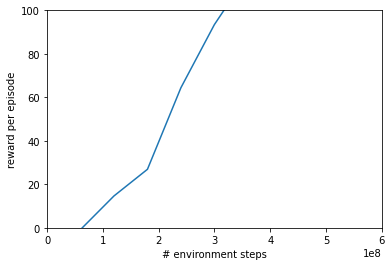

time to jit: 0:02:26.582831
time to train: 0:09:40.470276


In [3]:
#@title Training some pre-included Brax environments

# We determined some reasonable hyperparameters offline and share them here.
train_fn = {
  'ant': functools.partial(
      ppo.train, num_timesteps = 30000000, log_frequency = 20,
      reward_scaling = 10, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 5, num_minibatches = 32,
      num_update_epochs = 4, discounting = 0.97, learning_rate = 3e-4,
      entropy_cost = 1e-2, num_envs = 2048, batch_size = 1024
  ),
  'humanoid': functools.partial(
      ppo.train, num_timesteps = 50000000, log_frequency = 20,
      reward_scaling = 0.1, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 10, num_minibatches = 32,
      num_update_epochs = 8, discounting = 0.97, learning_rate = 3e-4,
      entropy_cost = 1e-3, num_envs = 2048, batch_size = 1024, seed=1
  ),
  'fetch': functools.partial(
      ppo.train, num_timesteps = 100_000_000, log_frequency = 20,
      reward_scaling = 5, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 20, num_minibatches = 32,
      num_update_epochs = 4, discounting = 0.997, learning_rate = 3e-4,
      entropy_cost = 0.001, num_envs = 2048, batch_size = 256
  ),
  'grasp': functools.partial(
      ppo.train, num_timesteps = 600_000_000, log_frequency = 10,
      reward_scaling = 10, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 20, num_minibatches = 32,
      num_update_epochs = 2, discounting = 0.99, learning_rate = 3e-4,
      entropy_cost = 0.001, num_envs = 2048, batch_size = 256
  ),
  'halfcheetah': functools.partial(
      ppo.train, num_timesteps = 100_000_000, log_frequency = 10,
      reward_scaling = 1, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 20, num_minibatches = 32,
      num_update_epochs = 8, discounting = 0.95, learning_rate = 3e-4,
      entropy_cost = 0.001, num_envs = 2048, batch_size = 512
  ),
  'ur5e': functools.partial(
      ppo.train, num_timesteps = 20_000_000, log_frequency = 20,
      reward_scaling = 10, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 5, num_minibatches = 32,
      num_update_epochs = 4, discounting = 0.95, learning_rate = 2e-4,
      entropy_cost = 1e-2, num_envs = 2048, batch_size = 1024,
      max_devices_per_host = 8
  ),
  'reacher': functools.partial(
      ppo.train, num_timesteps = 100_000_000, log_frequency = 20,
      reward_scaling = 5, episode_length = 1000, normalize_observations = True,
      action_repeat = 4, unroll_length = 50, num_minibatches = 32,
      num_update_epochs = 8, discounting = 0.95, learning_rate = 3e-4,
      entropy_cost = 1e-3, num_envs = 2048, batch_size = 256,
      max_devices_per_host = 8, seed = 1),
}[env_name]
max_y = {'ant': 6000, 
         'humanoid': 12000, 
         'fetch': 15, 
         'grasp': 100, 
         'halfcheetah': 8000,
         'ur5e': 10,
         'reacher': 5}[env_name]

min_y = {'reacher': -100}.get(env_name, 0)

xdata = []
ydata = []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

inference_fn, params, _ = train_fn(environment_fn=env_fn, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

The trainers return an inference function, parameters, and the final set of metrics gathered during evaluation.

# Saving and Loading Policies

Brax can save and load trained policies:

In [4]:
model.save_params('/tmp/params', params)
inference_fn = ppo.make_inference_fn(
    env.observation_size, env.action_size, True)
params = model.load_params('/tmp/params')

# Visualizing a Policy's Behavior

We can use the policy to generate a rollout for visualization:

In [ ]:
#@title Visualizing a trajectory of the learned inference function

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=0)
state = jit_env_reset(rng=rng)
while not state.done:
  rollout.append(state)
  act_rng, rng = jax.random.split(rng)
  act = jit_inference_fn(params, state.obs, act_rng)
  state = jit_env_step(state, act)

HTML(html.render(env.sys, [s.qp for s in rollout]))

ವಿದಾಯ! 👋